# Проект: Аналитика в Яндекс.Афише

В данном проекте необходимо сделать первый шаг к оптимизации маркетинговых затрат.
В распоряжении имеются данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

В проекте проанализируем:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент

## Шаг 1. Предобработка данных

Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

visits.info()
print('     -----------------')
orders.info()
print('     -----------------')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
     -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
     -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [2]:
print(orders.sample(3))
print('     ')

print(costs.sample(3))

visits.sample(3)


                    Buy Ts  Revenue                  Uid
28852  2018-01-10 20:08:00     1.71  7037329835069458634
1868   2017-06-23 16:54:00     2.44  2810698662626749694
48153  2018-05-20 19:24:00     1.83  7885373332814980637
     
      source_id          dt   costs
34            1  2017-07-05   22.11
1760          5  2018-04-06  118.16
1939          9  2017-10-02   22.74


,Device,End Ts,Source Id,Start Ts,Uid
209479,desktop,2017-08-23 10:43:00,5,2017-08-23 10:42:00,12549938567684521310
116435,desktop,2017-12-22 13:55:00,4,2017-12-22 13:55:00,11275107545649314671
278583,touch,2017-11-30 22:43:00,4,2017-11-30 22:42:00,1077109906743352574


В каждом из файлов имеются данные о датах, которые необходимо перевести в формат даты. Также для удобства, переименуем столбцы, запишем их в нижнем регистре.

In [3]:
# поменяем регистр в названиях столбцов
visits.columns = visits.columns.str.lower()
costs.columns = costs.columns.str.lower()
orders.columns = orders.columns.str.lower()

# уберем экстремальные значения в датасете заказов
orders = orders.query('revenue < 100').reset_index()

# переименуем названия столбцов
visits = visits.rename(columns={'source id':'source_id','end ts':'end','start ts':'start'})
orders = orders.rename(columns={'buy ts':'buy_ts'})

# преобразуем типы данных
visits['end'] = pd.to_datetime(visits['end'])
visits['start'] = pd.to_datetime(visits['start'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])



## Шаг 2. Построение отчётов и расчет метрик

В данном разделе проекта посмотрим на поведение пользователей серивиса. Для этого усредним всех пользователей и распределим по когортам. Таким образом мы сможем понять, как меняются показатели усредненного пользователя, зарегестрировашегося в том или ином месяце.

В ходе анализа ответим на следующие вопросы в разных категориях:

### Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?
- С каких устройств пользователи посещают сервис?
- Из каких источников приходят?
### Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)
### Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

### Аналитика по продукту и пользователям

#### Сколько людей пользуются в день, неделю, месяц? Расчет показателей DAU, WAU, MAU

In [4]:
visits['month'] = visits['start'].astype('datetime64[M]')
visits['date'] = visits['start'].astype('datetime64[D]')

# посчитаем среднее количество сессий в день/месяц/неделю
DAU = visits.groupby('date').agg({'uid':'nunique'}).mean().round()
print('DAU: ',int(DAU),' пользователей в день')

MAU = visits.groupby('month').agg({'uid':'nunique'}).mean().round()
print('MAU: ',int(MAU),' пользователей в месяц')

WAU = visits.groupby('date').agg({'uid':'nunique'}).mean().round()
WAU = WAU*7
print('WAU: ',int(WAU),' пользователей в неделю')


DAU:  908  пользователей в день
MAU:  23228  пользователей в месяц
WAU:  6356  пользователей в неделю


В среднем в месяц сайт посещают до 1000 пользователей  в день.

#### Сколько сессий в день?

In [5]:
sessions_per_day = visits.pivot_table(index='month',values='uid',aggfunc='count')/30
sessions_per_day.round()

,uid
month,
2017-06-01,550.0
2017-07-01,594.0
2017-08-01,478.0
2017-09-01,797.0
2017-10-01,1263.0
2017-11-01,1466.0
2017-12-01,1399.0
2018-01-01,1231.0
2018-02-01,1239.0


В разные месяцы активность пользователей разная. Так, наибольшее количество сессий наблюдается с октября по март. Возможно в холодное время года пользователям скучно и они заходят посмотреть на сайт различные мероприятия. А может быть им чаще, чем в летнее время, попадается на глаза реклама, и они переходят по ссылкам.

####  Сколько длится одна сессия?

count    292978.000000
mean          7.939149
std           7.442038
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max          29.000000
Name: duration, dtype: float64

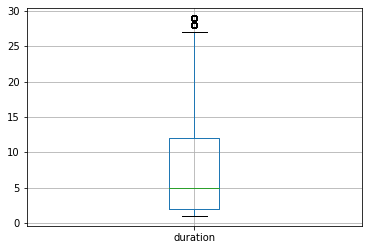

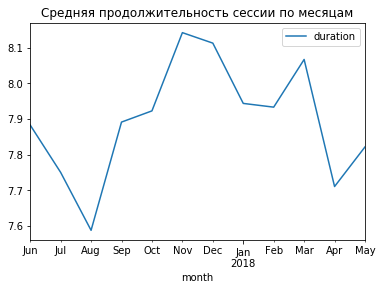

In [6]:
# длительность сессии
visits['duration'] = (visits['end'] - visits['start'])
visits['duration'] = visits['duration']/np.timedelta64(1,'m')
visits['duration'] = visits['duration'].astype('int')

# длительность сессии, где сессия > 0
visits = visits.query('duration > 0')

# исключим выбросы по длительности сессий
visits = visits.query('duration < 30')

visits.boxplot(column=['duration'])


visits.pivot_table(index='month',values='duration',aggfunc='mean')\
                  .plot(kind='line', title = 'Средняя продолжительность сессии по месяцам')
visits['duration'].describe()


50% пользователей проводят на сайте 5 мин. Кто-то больше, кто-то меньше.

Судя по графику, средняя продолжительности сессии в разные месяцы возрастает с начала октября, держится на пиковых значения в ноябре-декабре, а затем постепенно снижается.

#### Как часто пользователи возвращаются?

Распределим пользователей по когортам, в зависимости от первого месяца посещения.

In [7]:
# найдем первую дату посещения приложения пользователем
first_visit_day = visits.groupby(['uid'])['start'].min()
first_visit_day.name = 'first_visit_day'
visits = visits.join(first_visit_day,on='uid')

visits = visits.rename(columns={'first_visit_day':'date1'})
visits['date1'] = visits['date1'].astype('datetime64[D]')

# сформируем когорты пользователей на основе первого месяца посещения
visits['cohort_month'] = visits['date1'].astype('datetime64[M]')
visits['start_month'] = visits['start'].astype('datetime64[M]')
visits.sample(3)

,device,end,source_id,start,uid,month,date,duration,date1,cohort_month,start_month
334031,desktop,2018-01-04 12:37:00,3,2018-01-04 12:34:00,8812748462886284932,2018-01-01,2018-01-04,3,2018-01-04,2018-01-01,2018-01-01
347078,touch,2018-03-14 18:09:00,1,2018-03-14 17:50:00,13420753745037911157,2018-03-01,2018-03-14,19,2018-03-14,2018-03-01,2018-03-01
8856,desktop,2017-12-06 09:45:00,5,2017-12-06 09:43:00,11357512252375872202,2017-12-01,2017-12-06,2,2017-12-06,2017-12-01,2017-12-01


в результате мы получили датафрейм, где есть информация о пользователях по когортам. В зависимости от месяца, когда они впеврвые посетили сайт, мы сможем наблюдать, как меняется их поведение во времени.

In [8]:
visits['cohort_lifetime'] = visits['start_month'] - visits['cohort_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

visits.pivot_table(index='cohort_month', columns='cohort_lifetime',  values='uid', aggfunc='count', fill_value='')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06-01,13618.0,1710,1225,1575,1908,2066,1866,1571,1505,1447,1184,1153
2017-07-01,12968.0,885,919,1000,1038,847,729,742,625,468,469,
2017-08-01,9779.0,917,751,773,654,533,440,509,350,326,,
2017-09-01,16307.0,1635,1423,1058,768,734,716,453,466,,,
2017-10-01,25735.0,2459,1509,1122,972,892,599,576,,,,
2017-11-01,27591.0,2847,1572,1364,1042,618,647,,,,,
2017-12-01,24890.0,1707,1124,885,511,501,,,,,,
2018-01-01,22089.0,1709,1051,579,506,,,,,,,
2018-02-01,21762.0,1463,606,531,,,,,,,,


Мы получили жизненный цикл когорт: в дальнейшем это упростит отслеживание изменения показателей на разном этапе жизненного цикла.

Отобразим на графике, сколько в каждой когорте пользователей.

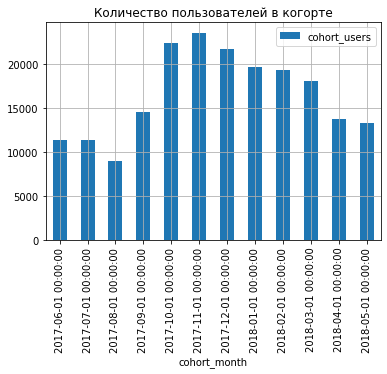

In [9]:
cohorts = visits.groupby(['cohort_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['cohort_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='cohort_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts.pivot_table(index='cohort_month',values='cohort_users')

cohorts.pivot_table(index='cohort_month',values='cohort_users').\
plot(kind='bar', title='Количество пользователей в когорте', grid = True)

На графике видно, что начиная с осеннего периода идет рост чесленности когорт. И после пиковых осенне-зимних месяцев, численность когорт постепенно снижается. Вероятно, это связано с тем, что зимой пользователи реже проводят время в отпусках, увеличивается спрос на развлекательную индустрию.

Далее посмотрим, как ведут себя пользователи этих когорт. Зная их общее количество, мы сможем увидеть, какая доля всей когорты  посещает сервис в разные месяцы.

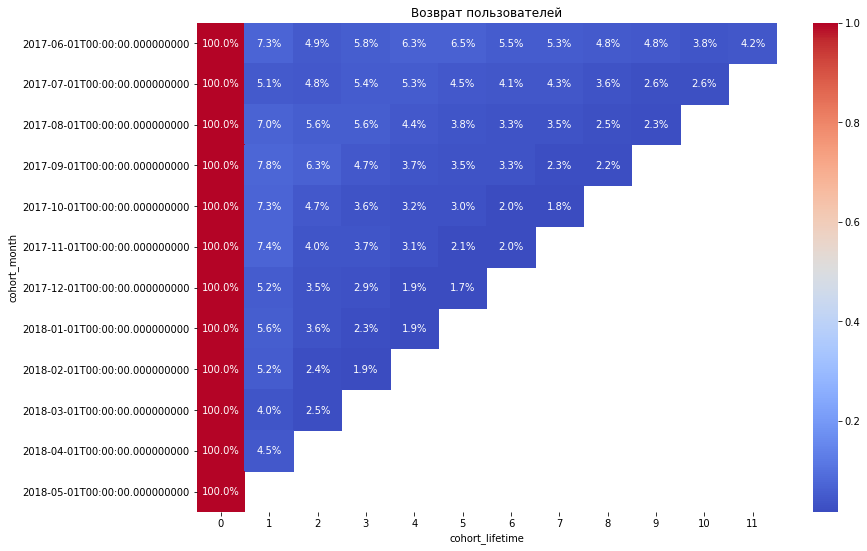

In [10]:
# расчитаем показатель удержания пользователей
retention_pivot = cohorts.pivot_table(index='cohort_month',columns='cohort_lifetime',
                                      values='retention',aggfunc='sum')


plt.figure(figsize=(13, 9))
plt.title('Возврат пользователей')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', cmap='coolwarm')


Исходя из сводной таблицы, видим, что процент возврата пользователей на сайт невелик и не превышает 10% на каждом этапе жизненного цикла когорты. Возможно, это одни и те же пользователи из месяца в месяц, которые оценили удобство сервиса и продолжили пользоваться им.

#### Аналитика в разрезе девайсов, источников

Создадим копию датасета, исключив ненужные столбцы. Далее будем работать с этим датасетом.

In [11]:
# подготовим данные для дальнейшего анализа (оставим только нужные столбцы)
session_data = visits[{'uid','date','month','source_id','device','cohort_month','cohort_lifetime','date1'}].copy()
session_data.sample(3)

,date1,month,uid,date,cohort_lifetime,device,source_id,cohort_month
16797,2018-01-02,2018-01-01,10505075499934394551,2018-01-02,0,touch,3,2018-01-01
141972,2017-07-12,2017-07-01,11548021210728998306,2017-07-12,0,desktop,3,2017-07-01
68596,2017-07-10,2017-10-01,6506683662973216629,2017-10-04,3,touch,4,2017-07-01



Посмотрим на пользователей с точки зрения источников, откуда они приходили на сервис, а также устройств, с которых они использовали сервис.

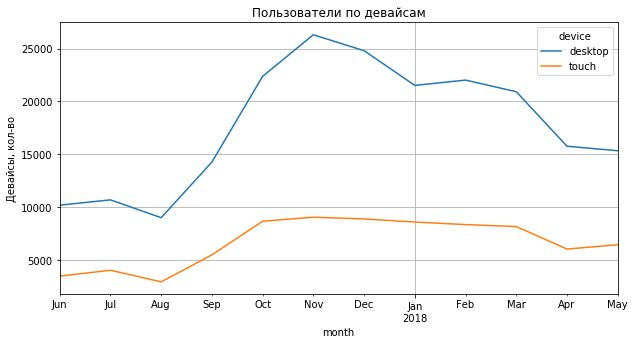

In [12]:
# аналитика по девайсам, источникам, во времени

session_data.pivot_table(index=['month'],columns='device',values='uid',aggfunc='count')\
            .plot(kind='line', grid=True, figsize=(10,5), title='Аналитика по устройствам')
            
plt.ylabel('Девайсы, кол-во')
plt.title('Пользователи по девайсам')

plt.show()  


На графике видим, что пользользователи предпочитают заходить на сайт сервиса с компьютера. Мобильная версия сервиса не пользуется популярностью.

Также видим, что активность возрастает, начиная с осеннего периода, и только ближе к весне начинает снижаться. Это характерно и для пользователей любых типов устройств.

Далее посмотрм, из каких источников пользователи переходят на страницу сервиса.

Text(0.5, 1.0, 'Распределение пользователей по источникам')

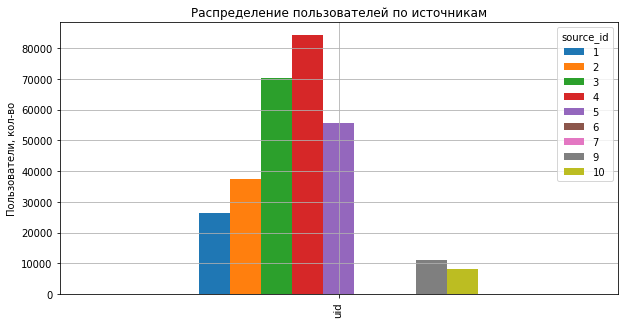

In [13]:
session_data.pivot_table(columns='source_id',values='uid',aggfunc='count')\
            .plot(kind='bar', grid=True, figsize=(10,5))

plt.ylabel('Пользователи, кол-во')
plt.title('Распределение пользователей по источникам')

Наиболее число пользователей приходит из источника под №4. Меньше всего пользователей приходит от источника №10. Источники №3 и №5 также вносят свой вклад в общую статистику.

###  Аналитика продаж

####  Когда пользователи совершают свою первую покупку?

Определим, когда пользователи совершают свою первую покупку. Добавим эти данные в общую таблицу о заказах пользователей.

In [14]:
# когда была сделана первая покупка
first_buy = orders.groupby(['uid'])['buy_ts'].min() 
first_buy.name = 'first_buy'

orders2 = orders.join(first_buy,on='uid')

orders2['first_buy_date'] = orders2['first_buy'].astype('datetime64[D]')
orders2['date'] = orders2['buy_ts'].astype('datetime64[D]')
orders2['buy_month'] = orders2['buy_ts'].astype('datetime64[M]')
orders2['first_buy_month'] = orders2['first_buy_date'].astype('datetime64[M]')

orders2.sample(3)

,index,buy_ts,revenue,uid,first_buy,first_buy_date,date,buy_month,first_buy_month
7517,7522,2017-09-11 23:24:00,0.78,4999376622754659413,2017-09-11 23:24:00,2017-09-11,2017-09-11,2017-09-01,2017-09-01
26923,26982,2017-12-29 16:04:00,4.03,3577449367987547907,2017-06-09 10:43:00,2017-06-09,2017-12-29,2017-12-01,2017-06-01
34742,34814,2018-02-14 15:24:00,3.05,10116135452198588850,2017-06-02 11:46:00,2017-06-02,2018-02-14,2018-02-01,2017-06-01


Добавим в таблицу информацию об этапах жизненного цикла когорты покупателей

In [15]:
orders2['cohort_lifetime2'] = orders2['buy_month'] - orders2['first_buy_month']
orders2['cohort_lifetime2'] = orders2['cohort_lifetime2'] / np.timedelta64(1,'M')
orders2['cohort_lifetime2'] = orders2['cohort_lifetime2'].round().astype('int')
orders2.sample(3)

,index,buy_ts,revenue,uid,first_buy,first_buy_date,date,buy_month,first_buy_month,cohort_lifetime2
38660,38736,2018-03-07 14:34:00,7.33,9475089746436224237,2017-11-23 16:23:00,2017-11-23,2018-03-07,2018-03-01,2017-11-01,4
16518,16544,2017-11-07 20:59:00,0.55,11114834656053171266,2017-11-07 20:59:00,2017-11-07,2017-11-07,2017-11-01,2017-11-01,0
20288,20325,2017-11-26 20:07:00,3.67,9845934797623122998,2017-11-26 20:07:00,2017-11-26,2017-11-26,2017-11-01,2017-11-01,0


In [16]:
orders3 = orders2.groupby(['uid','date','first_buy_date','first_buy_month','cohort_lifetime2'])\
            .agg({'revenue':'sum'}).reset_index()
orders3 = orders3.query('revenue < 100').copy()
orders3.sample(3)

users_source = session_data.groupby('uid')['source_id'].median().astype('int')
orders4 = orders3.merge(users_source,on='uid')
orders4.sample(3)

first_visit = session_data[{'uid','date1'}]
first_visit = first_visit.drop_duplicates().reset_index(drop= True)
first_visit.sample(2)

orders4 = orders4.merge(first_visit,on='uid')
orders4.sample(2)

,uid,date,first_buy_date,first_buy_month,cohort_lifetime2,revenue,source_id,date1
21676,9367757635095589952,2017-06-25,2017-06-05,2017-06-01,0,6.11,4,2017-06-05
38510,16645371833478735175,2018-05-28,2018-05-28,2018-05-01,0,2.63,7,2018-05-26


В результате вычислений, мы получили объединенный датасет с информацией о покупках и первом дне визита на сервис сайта. Теперь можем посчитать, на какой день от первого дня сессии, пользователей совершает покупку.

In [17]:
# добавим столбец с данными о том, на какой день от первого дня сессии совершался первый заказ

orders4['when_buy'] = orders4['first_buy_date'] - orders4['date1']
orders4['when_buy'] = orders4['when_buy'] / np.timedelta64(1,'D')
orders4['when_buy'] = orders4['when_buy'].astype(int)

orders_data = orders4.query('when_buy >= 0').copy()

print('Половина пользователей совершают покупку на',int(orders_data['when_buy'].median()),'день от 1 визита')
#print('В среднем пользователи совершают покупку на',int(orders_data['when_buy'].mean()),'день от 1 визита')

orders_data['when_buy'].describe()

Половина пользователей совершают покупку на 0 день от 1 визита


count    39833.000000
mean        18.431125
std         47.440649
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max        363.000000
Name: when_buy, dtype: float64

Таким образом, большинство пользователей делают свою первую покупку в тот же день, как впервые попали на сайт сервиса.

Однако есть и те, кто впервые совершает покупку лишь спустя долгое время. Такие случаи сдвигают среднее время покупки. Поэтому имеет смысл рассматривать в качестве среднего медианное значение.

#### Сколько раз за период совершают покупку

In [18]:
# посмотрим, сколько раз покупают за месячный период
orders_amount = orders_data.groupby(['first_buy_month','uid','cohort_lifetime2']).agg({'date':'count'}).reset_index()
orders_amount.columns = ['first_buy_month','uid','cohort_age','count_buy']
orders_amount.pivot_table(index='first_buy_month', columns='cohort_age',values='count_buy',aggfunc='count').round().fillna('')


cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1754.0,49,42,43,78,57,49,36,50,40,37,44
2017-07-01,1693.0,45,49,57,46,35,33,32,37,22,23,
2017-08-01,1206.0,55,47,39,32,27,27,38,15,28,,
2017-09-01,2256.0,112,86,61,45,57,60,34,41,,,
2017-10-01,3710.0,182,105,77,83,60,53,56,,,,
2017-11-01,3407.0,187,102,88,70,39,56,,,,,
2017-12-01,3642.0,118,93,81,45,57,,,,,,
2018-01-01,2902.0,101,79,36,39,,,,,,,
2018-02-01,3163.0,108,54,34,,,,,,,,


Таким образом, самое большое количество покупок наблюдается в первом месяце. Это выглядит логичным: если кто-то заходит на сервис Я.Афиша, то скорее всего у него есть намерение сделать заказ в ближайшее время, например сходить в кино на текущих или следующих выходных.
Во всех остальных месяцах каждой когорты мы видим резкое снижение числа покупок. Это может быть связно с тем, что пользователи не оценили удоство севиса. Либо покупка в первом месяце была спонтанной, вызвана интересом работы сервиса.

Теперь посмотрим, сколько покупок делает в среднем один покупатель на протяжении всего времени существования когорты.

In [19]:
# сколько покупок делает один пользователь
orders_amount.pivot_table(index='first_buy_month', columns='cohort_age',values='count_buy',aggfunc='mean').round().fillna('')

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.0,2,2,2,2,2,3,2,2,2,2,1
2017-07-01,1.0,2,2,1,1,2,1,1,1,1,2,
2017-08-01,1.0,2,2,2,2,2,1,1,2,1,,
2017-09-01,1.0,1,2,2,1,1,1,1,1,,,
2017-10-01,1.0,1,1,1,1,1,1,2,,,,
2017-11-01,1.0,1,1,2,1,1,1,,,,,
2017-12-01,1.0,2,2,2,2,1,,,,,,
2018-01-01,1.0,2,1,1,2,,,,,,,
2018-02-01,1.0,2,1,2,,,,,,,,


Если рассматривать среднего пользователя, то в течение всего времени существования когорты, он совершает покупки 1-3 раза за месяц.

#### Какой средний чек?

In [20]:
# какой средний чек в каждом месяце?

pivot_bill = orders_data.pivot_table(index='first_buy_month',columns='cohort_lifetime2',
                                 values='revenue',aggfunc={'mean'}).round(1)
pivot_bill.fillna('')


mean                                                          \
cohort_lifetime2   0     1    2     3     4    5     6    7     8     9    10   
first_buy_month                                                                 
2017-06-01        4.0   7.2  7.9  10.4   7.2  7.6   7.3  5.9     6   8.6  9.6   
2017-07-01        5.5   7.2  9.6   6.5   5.3  5.2   4.8  5.5   6.3  11.8  6.7   
2017-08-01        4.8   7.4  7.8   8.5    10  7.8   7.4  7.2  11.2   6.5        
2017-09-01        4.5  12.8  9.6  11.8  10.7  8.8  12.3    8   8.6              
2017-10-01        4.3   5.7  5.5   5.2     5  4.9     5  4.9                    
2017-11-01        4.3   4.5    5   8.1   5.1  4.3   5.4                         
2017-12-01        4.0   5.1  5.7   5.1   5.7  4.6                               
2018-01-01        3.8   6.1  6.1   6.5   3.4                                    
2018-02-01        3.9   5.2  3.8   3.6                                          
2018-03-01        4.2   4.4  6.6                                                
2018-04-01        4.3   5.4                                                     
2018-05-01        4.0                                                           
2018-06-01        3.4                                                           

                       
cohort_lifetime2   11  
first_buy_month        
2017-06-01        5.8  
2017-07-01             
2017-08-01             
2017-09-01             
2017-10-01             
2017-11-01             
2017-12-01             
2018-01-01             
2018-02-01             
2018-03-01             
2018-04-01             
2018-05-01             
2018-06-01

Средний чек  в первый месяц жизни когорты варьируется в пределах 3-5 у.е.

Часто в последующие месяцы можно наблюдать незначтельное увеличение среднего чека покупок. Это может быть связано с тем, что регулярные посетитили сервиса делают покупки независимо от стоимости услуги. Таким образом, средний чек возрастает.

##### Подготовим данные для расчета показателей LTV и затрат на привлечение

In [21]:
orders_x = orders4[{'uid','date','first_buy_month','cohort_lifetime2','revenue','source_id'}].copy()
orders_x.columns=['revenue','date','cohort_month','cohort_age','source_id','uid']
orders_x.sample(3)

,revenue,date,cohort_month,cohort_age,source_id,uid
37245,16040848215845679385,2017-12-22,2017-12-01,5,0,1.59
8877,3752854659575288722,2018-05-21,2018-05-01,10,0,0.73
26641,11475388497456242237,2018-04-07,2018-04-01,2,0,2.44


#### Посчитаем, сколько денег приносят покупатели на протяжении всего сущестования когорты? Расчет показателя LTV

Посмотрим, какой суммарный доход приносят клиенты в разрезе по разным когортам.

In [22]:
cohort_sizes = orders_x.groupby(['cohort_month','source_id']).agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['cohort_month','source_id','n_buyers']

cohorts = orders_x.groupby(['cohort_month','source_id','cohort_age']).agg({'revenue': 'sum'}).reset_index()
report = cohort_sizes.merge(cohorts, how='left', on=['cohort_month','source_id'])
report.sample(3)

report['ltv']= report['revenue']/report['n_buyers']
report.sample(3)

,cohort_month,source_id,n_buyers,cohort_age,revenue,ltv
312,2017-10-01,1,128,6,9.283351e+17,7.252618e+15
336,2017-10-01,4,72,6,2.215757e+18,3.077440e+16
417,2017-11-01,6,53,5,5.554208e+19,1.047964e+18


In [23]:
output7 = report.pivot_table(
    index='cohort_month', 
    columns='cohort_age', 
    values=['ltv'],
    aggfunc='mean')

output7.cumsum(axis=1).round(1).fillna('')


ltv                                          \
cohort_age             1            2            3             4    
cohort_month                                                        
2017-06-01    2.03874e+18  1.30782e+19  1.58482e+19  1.847974e+19   
2017-07-01    1.75962e+18  6.29136e+18  9.92699e+18  1.451007e+19   
2017-08-01    1.86839e+18  4.38844e+18   7.5591e+18  1.128121e+19   
2017-09-01    2.66859e+18  8.73939e+18  1.31655e+19  1.819868e+19   
2017-10-01     1.6027e+18  7.56108e+18  1.34111e+19  2.041971e+19   
2017-11-01    1.90498e+18  8.10821e+18  1.38839e+19  2.016934e+19   
2017-12-01    1.78533e+18  9.36251e+18  1.51386e+19  2.232853e+19   
2018-01-01    2.31861e+18  9.09885e+18  1.58737e+19  2.246307e+19   
2018-02-01    3.39106e+18  9.45545e+18    1.803e+19  2.539075e+19   
2018-03-01    2.57705e+18  1.21551e+19  1.89033e+19  2.745788e+19   
2018-04-01    6.03536e+18  1.43015e+19  2.46629e+19  3.737948e+19   
2018-05-01    8.09336e+18  2.58605e+19  5.15719e+19  7.462981e+19   
2018-06-01                                           8.387279e+16   

                                                                               
cohort_age             5            6            7            9            10  
cohort_month                                                                   
2017-06-01    2.00533e+19  2.03941e+19  2.06751e+19  2.11024e+19  2.35163e+19  
2017-07-01    1.67611e+19  1.71305e+19   1.7482e+19  1.82905e+19  1.91296e+19  
2017-08-01    1.49019e+19  1.52968e+19    1.569e+19  1.69966e+19  1.78118e+19  
2017-09-01    2.02705e+19  2.06447e+19  2.08334e+19  2.14396e+19  2.19169e+19  
2017-10-01    2.36096e+19  2.41483e+19  2.45972e+19  2.51941e+19  2.60709e+19  
2017-11-01    2.25503e+19   2.2903e+19  2.31431e+19  2.38296e+19  2.42397e+19  
2017-12-01    2.53246e+19  2.57519e+19   2.6028e+19  2.70118e+19  2.79807e+19  
2018-01-01    2.57472e+19  2.62622e+19  2.64885e+19   2.7274e+19  2.80694e+19  
2018-02-01    2.97697e+19  3.02893e+19  3.07915e+19  3.19658e+19  3.29205e+19  
2018-03-01    3.14373e+19  3.20365e+19   3.2559e+19   3.3838e+19   3.5038e+19  
2018-04-01    4.36316e+19  4.40696e+19   4.4323e+19  4.49757e+19  4.63946e+19  
2018-05-01    8.94362e+19  9.00302e+19  9.08134e+19   9.2352e+19  9.58573e+19  
2018-06-01

Накопленная жизненная ценность среднего клиента тем больше, чем дольше существует когорта. Так, самый большой накопительный доход наблюдается у покупателей из первой когорты.

### Аналитика расходов и доходов

#### Сколько денег потратили на маркетинг всего / на каждый источник / по времени?

Пострим график расходов на разные источники по привлечению пользователей.

Суммарно на все источники потратили  329131 у.е.


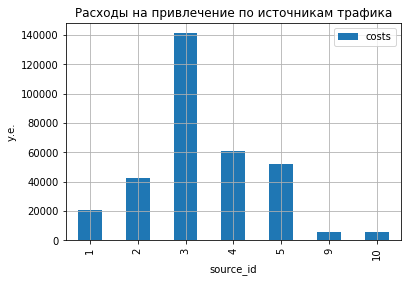

In [24]:
# Сколько денег потратили? Всего / на каждый источник / по времени

costs['month'] = costs['dt'].astype('datetime64[M]')
costs3 = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()


costs3.pivot_table(index='source_id',values='costs',aggfunc='sum').round().plot(kind='bar',grid=True)
plt.ylabel('у.е.')
plt.title('Расходы на привлечение по источникам трафика')

print('Суммарно на все источники потратили ',int(costs3['costs'].sum()), 'у.е.')

Всего на маркетинг было потрачено 329131 у.е.

Из всей этой суммы больше всего затрат ушло на источник привлечения №3.

Построим график расходов по месяцам.

Text(0.5, 1.0, 'Расходы на привлечение по месяцам')

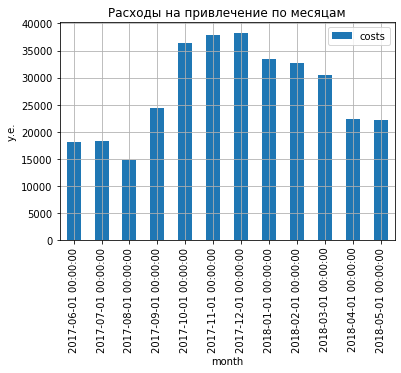

In [25]:
costs3.pivot_table(index='month',values='costs',aggfunc='sum').round().plot(kind='bar', label='Расходы',grid=True)
plt.ylabel('у.е.')
plt.title('Расходы на привлечение по месяцам')

Начиная с осенних месяцев затраты на маркетинг увеличиваются и находятся на пиковых значениях с октября по декабрь.

Ранее мы отмечали, что в осенне-зимние месяцы пришло больше всего пользователей (в сравненении с друними месяцами). Теперь нам известно, почему так произошло: сервис стал больше вкладываться в рекламу, стал более узнаваем, интерес к сервису вырос, как и количество пользователей пришедших на сайт впервые.

#### Сколько стоило привлечение одного покупателя из каждого источника?

Объеденим полученные данные с затратами маркетингового отдела на каждый источник привлечения

In [26]:
monthly_costs = costs.groupby(['month','source_id']).sum().reset_index()
report_0 = report.merge(monthly_costs,how='left', left_on=['cohort_month','source_id'], right_on=['month','source_id'])

report_0 = report_0.fillna(0)
report_0.sample(3)

report_0['CAC'] = report_0['costs'] / report_0['n_buyers']
report_02 = report_0.query('costs != 0').copy()
report_02.sample(3)

,cohort_month,source_id,n_buyers,cohort_age,revenue,ltv,month,costs,CAC
13,2017-06-01,1,72,5,3.795480e+19,5.271500e+17,2017-06-01 00:00:00,1125.61,15.633472
576,2018-04-01,1,75,4,1.828067e+20,2.437423e+18,2018-04-01 00:00:00,1327.49,17.699867
340,2017-10-01,5,60,1,1.884699e+19,3.141165e+17,2017-10-01 00:00:00,5767.40,96.123333


Далее посмотрим на стоимость привлечения одного клиента в зависимости от источника. Построим тепловую карту.

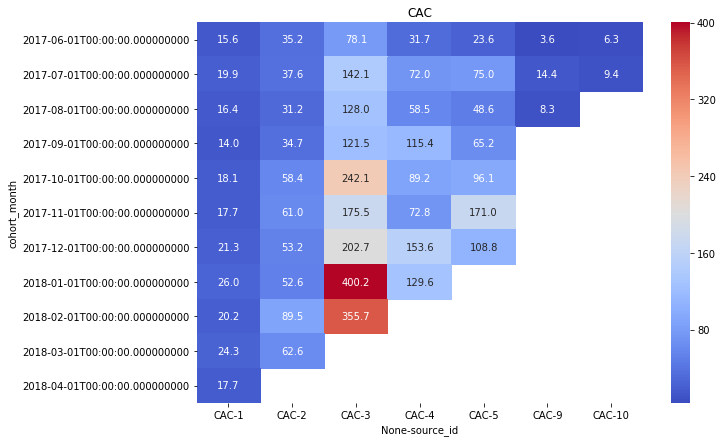

In [27]:
output3 = report_02.pivot_table(
    index='cohort_month', 
    columns='source_id', 
    values=['CAC'],
    aggfunc='mean')

output3.round(1)

plt.figure(figsize=(10, 7))
plt.title('CAC')
sns.heatmap(output3, annot=True, fmt='.1f', cmap='coolwarm')

На карте видим, что самые дорогие расходы по привлечению клиентов из источника №3.

In [28]:
report_02.pivot_table(index='cohort_month',columns='source_id',values='revenue',aggfunc='mean').round(1)

source_id,1,2,3,4,5,9,10
cohort_month,,,,,,,
2017-06-01,1.446504e+20,1.615576e+20,2.202452e+20,2.501060e+20,2.375657e+20,1.600492e+20,1.421230e+20
2017-07-01,7.822419e+19,9.896979e+19,7.845713e+19,6.358704e+19,7.590144e+19,4.073891e+19,5.450799e+19
2017-08-01,1.076778e+20,8.546492e+19,8.497179e+19,9.049920e+19,8.460916e+19,5.984938e+19,NaN
2017-09-01,2.020169e+20,1.725282e+20,1.500681e+20,7.567027e+19,1.141933e+20,NaN,NaN
2017-10-01,2.564045e+20,1.770253e+20,1.188160e+20,1.209510e+20,9.474382e+19,NaN,NaN
2017-11-01,4.087569e+20,1.734966e+20,1.900193e+20,1.104212e+20,6.098054e+19,NaN,NaN
2017-12-01,2.386357e+20,1.906038e+20,1.938253e+20,7.036108e+19,1.020128e+20,NaN,NaN
2018-01-01,1.686347e+20,1.273247e+20,5.999039e+19,7.742540e+19,NaN,NaN,NaN
2018-02-01,1.774686e+20,8.836368e+19,9.149640e+19,NaN,NaN,NaN,NaN


#### Когда окупаются расходы сервиса на привлечение. Расчет показателя ROI

Рассчитаем показатель ROI

In [29]:
report_02['ROI'] = report_0['ltv']/report_0['CAC']
report_02.head(3)

,cohort_month,source_id,n_buyers,cohort_age,revenue,ltv,month,costs,CAC,ROI
9,2017-06-01,1,72,1,6.202314e+19,8.614325e+17,2017-06-01 00:00:00,1125.61,15.633472,5.510180e+16
10,2017-06-01,1,72,2,8.436587e+20,1.171748e+19,2017-06-01 00:00:00,1125.61,15.633472,7.495124e+17
11,2017-06-01,1,72,3,1.111119e+20,1.543221e+18,2017-06-01 00:00:00,1125.61,15.633472,9.871259e+16


Посчитаем, на какой месяц окупаются затраты и бизнес начинает зарабатывать.

In [30]:
output11 = report_02.pivot_table(
    index='cohort_month',
    columns='cohort_age',
    values='ROI',
    aggfunc='mean')

output11.round(1)
output11.cumsum(axis=1).round(1).fillna('')

cohort_age,1,2,3,4,5,6,7,9,10
cohort_month,,,,,,,,,
2017-06-01,1.428519e+17,1.030079e+18,1.117497e+18,1.244399e+18,1.263520e+18,1.278111e+18,1.284478e+18,1.307622e+18,
2017-07-01,5.967380e+16,1.904455e+17,2.499475e+17,3.380276e+17,3.734920e+17,3.817538e+17,3.861077e+17,4.039758e+17,4.14153e+17
2017-08-01,4.635504e+16,1.689647e+17,2.592431e+17,3.716321e+17,4.829491e+17,4.886273e+17,4.952376e+17,5.376710e+17,5.46615e+17
2017-09-01,6.090098e+16,2.176818e+17,2.785461e+17,3.473562e+17,3.705788e+17,3.783548e+17,3.797983e+17,3.948938e+17,3.97952e+17
2017-10-01,2.851943e+16,1.219490e+17,1.921551e+17,2.783421e+17,3.066587e+17,3.090060e+17,3.122994e+17,3.227953e+17,3.2424e+17
2017-11-01,3.550904e+16,1.568627e+17,2.281655e+17,3.226533e+17,3.467518e+17,3.481026e+17,3.508663e+17,3.578165e+17,3.59875e+17
2017-12-01,1.013100e+16,1.258284e+17,1.683709e+17,2.291794e+17,2.540480e+17,2.577154e+17,2.616558e+17,2.755859e+17,
2018-01-01,2.546623e+16,1.228486e+17,1.706053e+17,2.154038e+17,2.320052e+17,2.390026e+17,2.400623e+17,2.460816e+17,2.52181e+17
2018-02-01,4.934002e+16,1.318450e+17,2.052750e+17,2.526846e+17,2.786527e+17,2.905953e+17,2.962416e+17,3.156855e+17,3.20683e+17


In [31]:
output11.cumsum(axis=1).mean(axis=0)

cohort_age
1     7.389003e+16
2     2.885408e+17
3     3.565268e+17
4     4.426275e+17
5     4.747479e+17
6     4.822498e+17
7     4.867744e+17
9     5.029485e+17
10    4.437362e+17
dtype: float64

В среднем, расходы на привлечение клиентов окупаются к 8 месяцу. То есть с 8 месяца сервис начинает работать в плюс.

### Вывод

От маркетинговых затрат напрямую зависит то, сколько людей придет и совершат покупку.

Однако есть различия между источниками привлечения новых пользователей. Чем дороже обходится привлечение клиентов, тем ниже % ROI (влоть до неокупаемости инвестиций).

Хотелось бы обратить внимание маркетологов на источник привлечения пользователей №3: затраты на привлечение пользователей самые высокие (в сравнении с другими источниками), а поток клиентов ниже, чем у источника №4, откуда приходит большинство посетителей на сайт сервиса.

С точки зрения ROI, сервис начинает себя окупать в среднем к 8 месяцу пользования сервисом. Поэтому имеет смысл уделить внимание такому показателю, как retention. Чем больше пользователей возвращается, тем дольше существует когорта, тем больше прибыль с данной когорты.

Также, на судя по графикам, есть все основания полагать, что пользователи предпочитают совершать покупки с десктопных устройств. Вероятно, когда есть возможность, пользователи предпочитают выбирать услуги сервиса Я.Афиша на большом экране компьютера. Поэтому имеет смысл в дальнейшем сосредоточиться на улучшении качества и удобства сервиса полноценной версии.